# To plot Tsne feature representation.  

In [1]:
import torch
import pickle
from scipy.io import loadmat
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_1k = pd.read_csv('./datasets/processed/combined_wofflins_real.csv')
df_5k = pd.read_csv('./datasets/processed/real_wofflin_scores_combined_normalised.csv')
combined = [df_1k, df_5k]
df = pd.concat(combined)

In [3]:
df['name'] = df['Input.image'].apply(lambda x: Path(x).name)

for j,i in enumerate(df['name']):
    try:
        b=i.split('.')[0]
        year=int(b.split('-')[-1])
        if year < 1400 or year > 2000:
            print('remove :',i, year)
    except:
        print(i,j)

161_not_detected_251590.jpg!Blog.jpg 223
145_not_detected_251621.jpg!Blog.jpg 1985
160_not_detected_251609.jpg!Blog.jpg 2142


In [4]:
def get_year(row):
    try:
        y = int(row['name'].split('.')[0].split('-')[-1])
        if int(y) < 1400:
            y = None  
        if int(y) > 2000:
            y = None 
    except ValueError:
        y = None
    return y

In [5]:
df.drop(df.index[[223,1985,2142]], inplace=True)
df['year'] = df.apply(get_year, axis=1)
df['year'] = df['year'].astype(int)

In [6]:
df = df.sort_values(by='year')
df.head()

,Input.image,Linearly-vs-Painterly,Planar-vs-Recessional,closed-form-vs-open-form,multiplicity-vs-unity,absolute-clarity-vs-relative-clarity,Unnamed: 0,name,year
2214,https://crw2020.s3-us-west-2.amazonaws.com/ran...,0.55,0.500,0.400,0.50,0.35,2214.0,31_virgin-and-child-1410.jpg!Blog.jpg,1410
502,https://crw2020.s3-us-west-2.amazonaws.com/ran...,0.40,0.650,0.050,0.65,0.25,NaN,29_trinity-of-the-broken-body-1410.jpg!Blog.jpg,1410
1298,https://crw2020.s3-us-west-2.amazonaws.com/ran...,0.40,0.350,0.150,0.30,0.20,1298.0,14_saint-john-the-baptist-1415.jpg!Blog.jpg,1415
2174,https://crw2020.s3-us-west-2.amazonaws.com/ran...,0.80,0.400,0.200,0.80,0.65,2174.0,318_madonna-of-humility-1420.jpg!Blog.jpg,1420
4134,https://crw2020.s3-us-west-2.amazonaws.com/ran...,0.70,0.375,0.125,0.35,0.70,4134.0,66_crucifixion-with-the-virgin-john-the-evange...,1420


In [7]:
mat_file = loadmat('/home/khanff/waga/WAGA/analyses_notebooks/datasets/processed/groundtruth_pruned.mat')
files = [Path(f[0][0]).name for f in mat_file['groundtruth_pruned'][0][0][0]]
real_indexes = [files.index(f) for f in df.name.values]

In [8]:
all_years = list(range(1500, 2001, 100))
all_years

[1500, 1600, 1700, 1800, 1900, 2000]

In [9]:
import matplotlib
cmap_string = 'jet'
cmap = matplotlib.cm.get_cmap(cmap_string)
cmap

cmap_values = (np.array(all_years) - 1400) / 600
colors = cmap(cmap_values)
colors

array([[0.        , 0.15882353, 1.        , 1.        ],
       [0.        , 0.83333333, 1.        , 1.        ],
       [0.49019608, 1.        , 0.47754586, 1.        ],
       [1.        , 0.90123457, 0.        , 1.        ],
       [1.        , 0.27668845, 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

In [10]:
sample_per_increment = 1000
colors = colors[:, None].repeat(sample_per_increment, axis=1)
colors = colors.reshape(-1, colors.shape[-1])
colors = colors[:df.shape[0]]

In [11]:
real_features = './datasets/features/real_art_features/'
generated_features = './datasets/features/generated_art_features/'
folder_generated = os.listdir(generated_features)
resnet50_real=3
resnet50_gen = [19,22]
vit_real = -4
vit_gen = [-5,-2]
gen_files = folder_generated[19:22]
real_file = os.listdir(real_features)[3]

In [12]:
# gen_files.append('vit_StyleGAN2.pkl')
gen_files.append('resnet50_StyleGAN2.pkl')

In [13]:
gen_files, real_file

(['resnet50_StyleCAN2.pkl',
  'resnet50_StyleCWAN1.pkl',
  'resnet50_StyleCWAN2.pkl',
  'resnet50_StyleGAN2.pkl'],
 'resnet50_pretrained_real.pkl')

In [14]:
with open(os.path.join(real_features, real_file), 'rb') as f:
    feats = pickle.load(f)
print(os.path.join(real_file))
real_feats = feats[real_indexes]

resnet50_pretrained_real.pkl


In [15]:
generated_feats = np.zeros((1600, real_feats.shape[1]))
for idx,file_gen in enumerate(gen_files):
    with open(os.path.join(generated_features, file_gen), 'rb') as f:
        feats = pickle.load(f)
    print(os.path.join(generated_features, file_gen))
    generated_feats[idx*400:(idx+1)*400] = feats

./datasets/features/generated_art_features/resnet50_StyleCAN2.pkl
./datasets/features/generated_art_features/resnet50_StyleCWAN1.pkl
./datasets/features/generated_art_features/resnet50_StyleCWAN2.pkl
./datasets/features/generated_art_features/resnet50_StyleGAN2.pkl


In [16]:
t = TSNE(n_components=2, random_state=16) 

all_feats = np.concatenate((real_feats, generated_feats), axis=0)

tsne_transformed_feats = t.fit_transform(all_feats)
sampled_all_feats_embedded = tsne_transformed_feats[:real_feats.shape[0]]
gen_feats = tsne_transformed_feats[real_feats.shape[0]:]

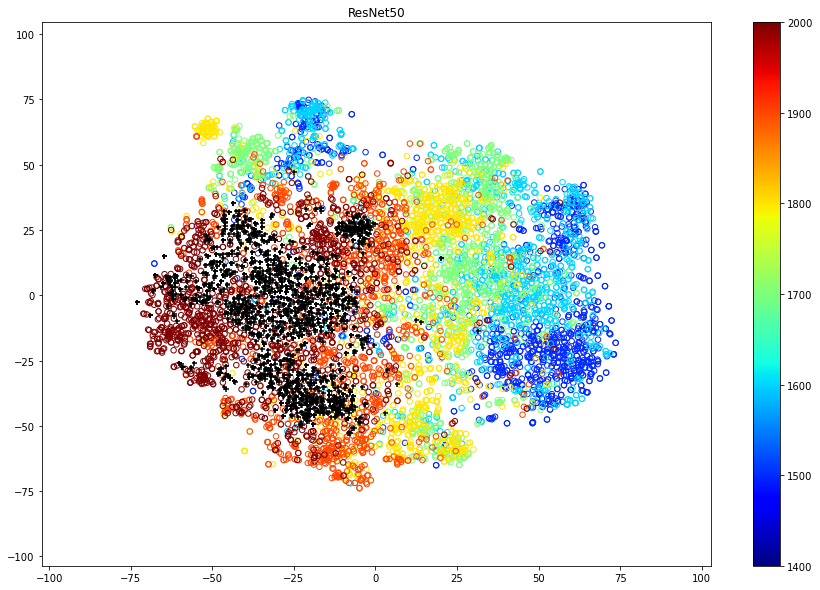

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
ax.margins(0.2,0.2)
ax.set_title('ResNet50')
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=1400, vmax=2000), cmap=cmap))
ax.scatter(sampled_all_feats_embedded[:,0], sampled_all_feats_embedded[:,1],
          s=30,
          edgecolors=colors,
          facecolor='none'
        )
ax.scatter(gen_feats[:, 0], gen_feats[:, 1],
            s=25,
            marker='+',
            color='black'
        )